In [ ]:
# original dataset available at https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction

# setup code
import time
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, metrics, tree
import graphviz
import keras as K

%matplotlib inline

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
# confusion matrix code from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
# import dataset

# dataset has already been split for us
train_url = 'https://raw.githubusercontent.com/krzysztofgb/CS412_Final/main/train.csv?token=AF3LFOUVGIUHMXGKLTE3RALAT3TL4'
test_url = 'https://raw.githubusercontent.com/krzysztofgb/CS412_Final/main/test.csv?token=AF3LFOUE2Z735IDNZDDIU23AT3TM6'

# delete first two columns, row number and ID (irrelevant to classification)
train = pd.read_csv(train_url)

print(train.head())
print("")

train.drop(train.columns[0:2],axis=1,inplace=True)

test = pd.read_csv(test_url)
test.drop(test.columns[0:2],axis=1,inplace=True)

feature_names = list(train.columns)[:-1]
class_names = train.satisfaction.unique()

print(train.head())
print("")
print(test.head())

   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel     Class  Flight Distance  Inflight wifi service  Departure/Arrival time convenient  Ease of Online booking  Gate location  Food and drink  Online boarding  Seat comfort  Inflight entertainment  On-board service  Leg room service  Baggage handling  Checkin service  Inflight service  Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes             satisfaction
0           0   70172    Male     Loyal Customer   13  Personal Travel  Eco Plus              460                      3                                  4                       3              1               5                3             5                       5                 4                 3                 4                4                 5            5                          25                      18.0  neutral or dissatisfied
1           1    5047    Male  disloyal Customer   25  Business travel  Business              235         

In [ ]:
# more data preprocessing
for col in train.columns:
  train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
  test[col] = preprocessing.LabelEncoder().fit_transform(test[col])

X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

print(X_train.head())
print(y_train.head())
print("")
print(X_test.head())
print(y_test.head())

   Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  Inflight wifi service  Departure/Arrival time convenient  Ease of Online booking  Gate location  Food and drink  Online boarding  Seat comfort  Inflight entertainment  On-board service  Leg room service  Baggage handling  Checkin service  Inflight service  Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes
0       1              0    6               1      2              358                      3                                  4                       3              1               5                3             5                       5                 4                 3                 3                4                 5            5                          25                        18
1       1              1   18               0      0              144                      3                                  2                       3              3               1                3             

Time elapsed: 3.912688732147217
Number of mislabeled points out of a total 25976 points : 6699



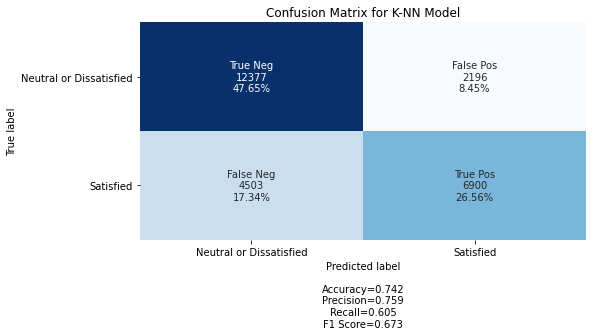

In [ ]:
# employ K-Nearest Neighbors model
start = time.time()
knn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
y_pred = knn.predict(X_test)
end = time.time()
print(f'Time elapsed: {end - start}')

print(f"Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != y_pred).sum()}")
print("")

cf = metrics.confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neutral or Dissatisfied', 'Satisfied']
make_confusion_matrix(cf, figsize=(8,4), cbar=False, group_names=labels, categories=categories, title='Confusion Matrix for K-NN Model')
plt.show()

Time elapsed: 0.05373740196228027
Number of mislabeled points out of a total 25976 points : 3529



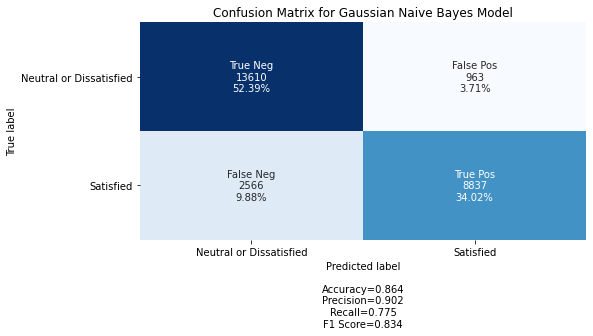

In [ ]:
# employ Gaussian Naive Bayes model
start = time.time()
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
end = time.time()
print(f'Time elapsed: {end - start}')

print(f"Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != y_pred).sum()}")
print("")

cf = metrics.confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neutral or Dissatisfied', 'Satisfied']
make_confusion_matrix(cf, figsize=(8,4), cbar=False, group_names=labels, categories=categories, title='Confusion Matrix for Gaussian Naive Bayes Model')

Time elapsed: 0.7669124603271484
Number of mislabeled points out of a total 25976 points : 2395



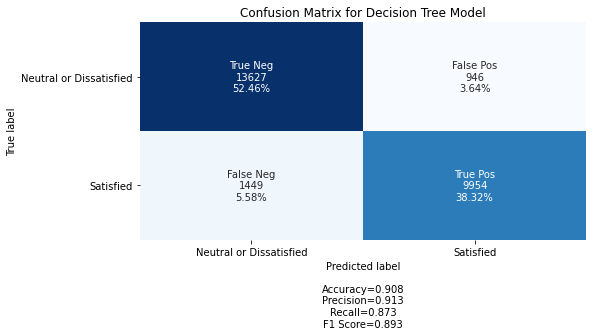

In [ ]:
# employ Decision Tree model
start = time.time()
dtree = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dtree.predict(X_test)
end = time.time()
print(f'Time elapsed: {end - start}')

print(f"Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != y_pred).sum()}")
print("")

cf = metrics.confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neutral or Dissatisfied', 'Satisfied']
make_confusion_matrix(cf, figsize=(8,4), cbar=False, group_names=labels, categories=categories, title='Confusion Matrix for Decision Tree Model')

# these decision trees are absolutely massive without tuning parameters like max_depth
# see here: https://raw.githubusercontent.com/krzysztofgb/CS412_Final/main/decision_tree.png?token=AF3LFOVVA432JMJWWRC7SJDARYUS2

# graphical representation
# tree_data = tree.export_graphviz(dtree, feature_names=feature_names, class_names=class_names)
# graph = graphviz.Source(tree_data)
# graph

# this also works but it's too big for Google Colab to handle
# tree.plot_tree(dtree, feature_names=feature_names, class_names=class_names, filled=True)

# text representation
# graph = tree.export_text(dtree, feature_names=feature_names)
# print(graph)

Time elapsed: 13.68314003944397
Number of mislabeled points out of a total 25976 points : 1325



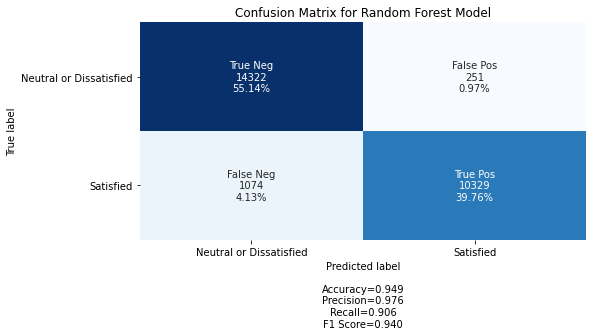

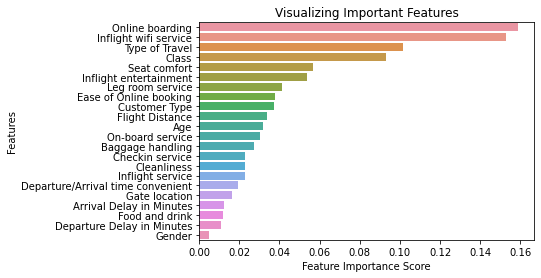

In [ ]:
# employ Random Forest model
start = time.time()
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
end = time.time()
print(f'Time elapsed: {end - start}')

print(f"Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != y_pred).sum()}")
print("")

cf = metrics.confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neutral or Dissatisfied', 'Satisfied']
make_confusion_matrix(cf, figsize=(8,4), cbar=False, group_names=labels, categories=categories, title='Confusion Matrix for Random Forest Model')
plt.show()

print("")
print("")
print("")

feature_imp = pd.Series(random_forest.feature_importances_,index=feature_names).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Visualizing Important Features")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

Epoch 1/50
812/812 [==============================] - 2s 2ms/step - loss: 1.1728 - accuracy: 0.5602 - val_loss: 0.6857 - val_accuracy: 0.5610
Epoch 2/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6837 - accuracy: 0.5689 - val_loss: 0.6857 - val_accuracy: 0.5610
Epoch 3/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6842 - accuracy: 0.5671 - val_loss: 0.6858 - val_accuracy: 0.5610
Epoch 4/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6848 - accuracy: 0.5645 - val_loss: 0.6858 - val_accuracy: 0.5610
Epoch 5/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6840 - accuracy: 0.5676 - val_loss: 0.6857 - val_accuracy: 0.5610
Epoch 6/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6845 - accuracy: 0.5659 - val_loss: 0.6858 - val_accuracy: 0.5610
Epoch 7/50
812/812 [==============================] - 1s 1ms/step - loss: 0.6834 - accuracy: 0.5696 - val_loss: 0.6857 - val_accuracy: 0.5610
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


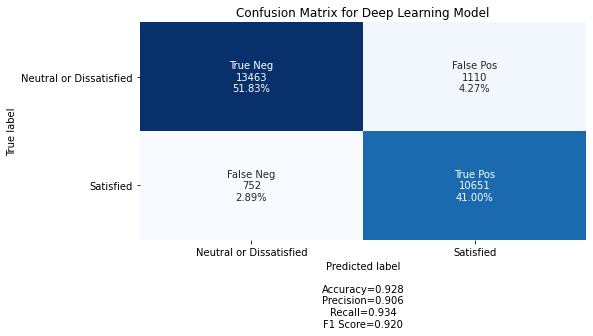

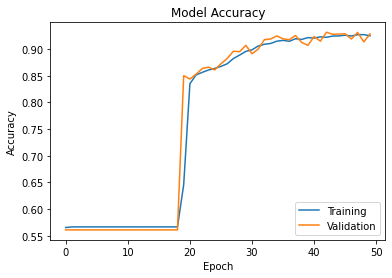

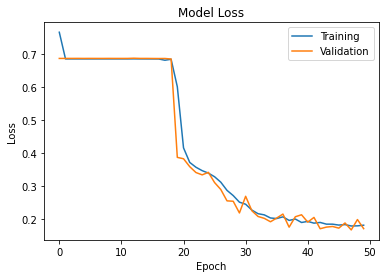

In [ ]:
# employ Keras Deep Learning/Neural Network (22-16-8-4-2-1) model
# visualization of model here https://raw.githubusercontent.com/krzysztofgb/CS412_Final/main/nn.svg?token=AF3LFOQHS3GWWO2JYFY6W3LARZBW4

model = K.models.Sequential()
model.add(K.layers.Dense(22, input_dim=22))
model.add(K.layers.Dense(16, activation='relu'))
model.add(K.layers.Dense(8, activation='relu'))
model.add(K.layers.Dense(4, activation='relu'))
model.add(K.layers.Dense(2, activation='relu'))
model.add(K.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))
end = time.time()
print(f'Time elapsed: {end - start}')

y_pred = model.predict_classes(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Neutral or Dissatisfied', 'Satisfied']
make_confusion_matrix(cf, figsize=(8,4), cbar=False, group_names=labels, categories=categories, title='Confusion Matrix for Deep Learning Model')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()